In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

## DF Parsing + Pre-Processing

In [2]:
df_undernourishment = pd.read_csv("..\..\Datasets\Processed\Prevalence_of_Undernourishment_Processed.csv")
df_net_fdi = pd.read_csv("..\..\Datasets\Processed/Net_FDI_Processed.csv")
df_cpi = pd.read_csv("..\..\Datasets\Processed\CPI_Food_Processed.csv", encoding="ISO-8859-1")
df_socio_factors = pd.read_csv("..\..\Datasets\Processed\SocioFactors_Processed.csv", encoding="ISO-8859-1")


In [3]:
df_undernourishment.rename(columns={'Prevalence_of_undernourishment_2016': "2016_(%)",'Prevalence_of_undernourishment_2017': "2017_(%)",'Prevalence_of_undernourishment_2018': "2018_(%)",'Prevalence_of_undernourishment_2019': "2019_(%)", 'Prevalence_of_undernourishment_2020': "2020_(%)"}, inplace=True)
df_undernourishment = df_undernourishment.replace("<2.5", "1.5")

df_cpi.rename(columns={"ISO3 Code": "ISO3_Code"}, inplace=True) # remove after CPI df col naming resolved
df_undernourishment.drop("Unnamed: 0", axis=1, inplace=True)
df_net_fdi.drop("Unnamed: 0", axis=1, inplace=True)

print(df_undernourishment.columns)
print(df_net_fdi.columns)
print(df_cpi.columns)
print(df_socio_factors.columns)

Index(['M49_Code', 'Country_Name', '2016_(%)', '2017_(%)', '2018_(%)',
       '2019_(%)', '2020_(%)'],
      dtype='object')
Index(['M49_Code', 'Country_Name', 'Total_FDI_Inflows_2016',
       'Total_FDI_Inflows_2017', 'Total_FDI_Inflows_2018',
       'Total_FDI_Inflows_2019', 'Total_FDI_Inflows_2020',
       'Total_FDI_Outflows_2016', 'Total_FDI_Outflows_2017',
       'Total_FDI_Outflows_2018', 'Total_FDI_Outflows_2019',
       'Total_FDI_Outflows_2020', 'Net_FDI_2016', 'Net_FDI_2017',
       'Net_FDI_2018', 'Net_FDI_2019', 'Net_FDI_2020'],
      dtype='object')
Index(['M49_Code', 'Country_Name', 'ISO3_Code', 'CPI_Food_2016',
       'CPI_Food_2017', 'CPI_Food_2018', 'CPI_Food_2019', 'CPI_Food_2020',
       'CPI_Food_Avg'],
      dtype='object')
Index(['ISO3_Code', 'Country_Name', 'M49_Code', 'Life_Expectancy_2016',
       'Life_Expectancy_2017', 'Life_Expectancy_2018', 'Life_Expectancy_2019',
       'Life_Expectancy_2020', 'Life_Expectancy_Avg',
       'Mean_Years_Of_Schooling_2016', 

In [4]:
# print(df_undernourishment.dtypes)
# print(df_net_fdi.dtypes)
print(df_cpi.dtypes)
print(df_socio_factors.dtypes)

M49_Code           int64
Country_Name      object
ISO3_Code         object
CPI_Food_2016    float64
CPI_Food_2017    float64
CPI_Food_2018    float64
CPI_Food_2019    float64
CPI_Food_2020    float64
CPI_Food_Avg     float64
dtype: object
ISO3_Code                        object
Country_Name                     object
M49_Code                        float64
Life_Expectancy_2016            float64
Life_Expectancy_2017            float64
Life_Expectancy_2018            float64
Life_Expectancy_2019            float64
Life_Expectancy_2020            float64
Life_Expectancy_Avg             float64
Mean_Years_Of_Schooling_2016    float64
Mean_Years_Of_Schooling_2017    float64
Mean_Years_Of_Schooling_2018    float64
Mean_Years_Of_Schooling_2019    float64
Mean_Years_Of_Schooling_2020    float64
Mean_Years_of_Schooling_Avg     float64
dtype: object


### Relevant Plotting Functions


In [5]:
PLOTS_TO_FUNC = {
    "Hist": sns.histplot,
    "KDE": sns.kdeplot,
    "Ecdf": sns.ecdfplot,
    "Bar": sns.barplot,
    "Scatter": sns.scatterplot,
    "Violin": sns.violinplot,
    "Line": sns.lineplot
}


In [6]:
def custom_settings(
    markersize: float = 2,
    linewidth: float = 0.5,
    labelsize: float = 6.5
):
    mpl.rcdefaults()
    mpl.rcParams["lines.markersize"] = markersize
    mpl.rcParams["lines.linewidth"] = linewidth
    mpl.rcParams["xtick.labelsize"] = labelsize
    ax = plt.gca()
    ax.set_xlim((0, 55))
    # simplefilter(action="ignore")

# custom_settings()

In [7]:
def split_cols_exceeding_thresh(
    df: pd.DataFrame,
    label_name: str,
    thresh: int = 5
) -> dict:
    """
    For the cols that exceed the categorical threshold 
        => This function will break down the unique vals of the col into n groups
            where n = n_unique values of the col / categorical threshold
    Returns dictionary where:
        keys => arbitrary names (1,2,3,4,...)
        values => list of values in the label col split according to the threshold
    """
    d = {}
    n_cuts = int(np.ceil((df[label_name].nunique()) / thresh))
    l = df[label_name].sort_values()
    col_names_l = np.array_split(l, n_cuts) 
    var_name_l = [i for i in range(0, n_cuts)]
    for j in range(len(var_name_l)):
        d[var_name_l[j]] = col_names_l[j]
    return d


In [75]:
def rotate_axis(
    fig,
) -> bool:
    """
    Dynamic rotation of x axis labels
    """
    num_labels = len(fig.get_xticklabels())
    if num_labels >= 5:
        return True
    else:
        return False

def save_fig(
    fig,
    dest_path,
    file_name
):
    locs, labels = plt.xticks()
    if rotate_axis(fig):
        plt.setp(labels,rotation=45, horizontalalignment="right")
    else:
        plt.setp(labels, horizontalalignment="right")

    plt.savefig(os.path.join(dest_path, file_name), dpi=300, bbox_inches="tight")
    plt.close()

## Univariate Analysis

In [9]:
## Making Targeted Dir for plots to be saved in

cwd = os.getcwd()
UNIVARIATE = os.path.join(cwd,"Graphs/Graphs_EDA/Univariate_Analysis")
BIVARIATE = os.path.join(cwd,"Graphs/Graphs_EDA/Bivariate_Analysis")
if not os.path.isdir(UNIVARIATE):
    os.makedirs(UNIVARIATE)
if not os.path.isdir(BIVARIATE):
    os.makedirs(BIVARIATE)

plot_types_uni = ["Hist", "KDE"]

In [14]:
cols_dict1 = {
    "Prevalence" : ["2016_(%)", "2017_(%)", "2018_(%)","2019_(%)","2020_(%)"],
    "Life_Expectancy" : ['Life_Expectancy_2016','Life_Expectancy_2017', 'Life_Expectancy_2018', 'Life_Expectancy_2019','Life_Expectancy_2020', 'Life_Expectancy_Avg'],
    # "CPI": ['CPI_Food_2016', 'CPI_Food_2017', 'CPI_Food_2018', 'CPI_Food_2019', 'CPI_Food_2020','CPI_Food_Avg'],
    "Net_FDI": ['Net_FDI_2016', 'Net_FDI_2017','Net_FDI_2018', 'Net_FDI_2019', 'Net_FDI_2020']
}



# for k,v in cols_dict.items():
#     df = pd.DataFrame
#     if k == "Prevalence":
#         df = df_undernourishment
#     elif k == "Life_Expectancy":
#         df = df_socio_factors
#     elif k == "CPI":
#         df = df_cpi
#     elif k == "Net_FDI":
#         df = df_net_fdi
#     print(k)
#     for col in cols_dict[k]:
#         for plot_type in plot_types_uni:
#             fig = PLOTS_TO_FUNC[plot_type](data=df, x=col)
#             file_name = f"{plot_type}_plot_{col}.png"
#             save_fig(fig, UNIVARIATE, file_name)



## All Processed Dataset
### Creating Categories from Numerical Cols


In [57]:
df_all_processed = pd.read_csv("..\..\Datasets\Processed\All_Processed.csv")
df_all_processed.sort_values(by="Country_Name", inplace=True)

In [58]:
df_all_processed.columns

Index(['ISO3_Code', 'Country_Name', 'M49_Code', 'Year', 'Life_Expectancy',
       'Mean_Years_Of_Schooling', 'CPI_Food', 'Net_FDI',
       'Infant_Mortality_Rate', 'Unemployment', 'Access_To_Electricity',
       'Fertility_Rate', 'Immunization_Measles', 'Labor_Force_Gender_Ratio',
       'Corruption_Perception_Index', 'Prevalence_of_undernourishment'],
      dtype='object')

In [137]:
## Life Expectancy
df_all_processed["Life_Expectancy_Cat"] = pd.cut(df_all_processed["Life_Expectancy"], bins=[51,60,70,80,90], labels=["51-60","61-70","71-80","81-90"])
# df_all_processed["Life_Expectancy_Cat"] = pd.cut(df_all_processed["Life_Expectancy"], bins=[51,55,60,65,70,75,80,85,90], labels=["51-55","56-60","61-65","66-70","71-75","76-80","81-85","86-90"])

## Net FDI
df_all_processed["Net_FDI_Cat"] = pd.cut(df_all_processed["Net_FDI"], bins=[-400000,-200000,0,200000, 400000, 600000], labels=["<-200000","(-200000)-0","0-200000","200000-400000", ">400000"])

## CPI
print(df_all_processed["CPI_Food"].max())
print(df_all_processed["CPI_Food"].min())
# CPI has a big outlier data points, might not be ideal for this
df_all_processed.sort_values(by="CPI_Food", ascending=False)

38753710727.95829
86.673816


,ISO3_Code,Country_Name,M49_Code,Year,Life_Expectancy,Mean_Years_Of_Schooling,CPI_Food,Net_FDI,Prevalence_of_undernourishment,Life_Expectancy_Cat,Net_FDI_Cat
754,VEN,Venezuela (Bolivarian Republic of),862.0,2020,71.0949,11.107277,3.875371e+10,1037.333334,22.9,71-80,0-200000
602,VEN,Venezuela (Bolivarian Republic of),862.0,2019,72.1614,11.107277,1.288889e+09,-142.000000,24.9,71-80,(-200000)-0
450,VEN,Venezuela (Bolivarian Republic of),862.0,2018,71.9788,10.835699,1.594700e+07,225.000000,22.7,71-80,0-200000
298,VEN,Venezuela (Bolivarian Republic of),862.0,2017,71.9430,10.570760,1.108619e+04,-2302.000000,22.2,71-80,(-200000)-0
728,SDN,Sudan,729.0,2020,65.6136,3.820000,1.621521e+03,1284.407750,12.8,61-70,0-200000
...,...,...,...,...,...,...,...,...,...,...,...
741,TCD,Chad,148.0,2020,52.7774,2.573774,9.113692e+01,1284.407750,32.7,51-60,0-200000
285,TCD,Chad,148.0,2017,52.3076,2.388869,9.091219e+01,204.867505,29.1,51-60,0-200000
133,TCD,Chad,148.0,2016,52.0834,2.301459,8.902543e+01,3457.305457,28.5,51-60,0-200000
437,TCD,Chad,148.0,2018,52.8253,2.479598,8.678160e+01,3746.793298,30.3,51-60,0-200000


In [140]:
fig = sns.histplot(data=df_all_processed, x="Prevalence_of_undernourishment", hue="Life_Expectancy_Cat")
save_fig(fig, UNIVARIATE, "Hist_plot_Prevalence_hue_life_expectancy.png")


In [145]:
fig = sns.histplot(data=df_all_processed, x="Prevalence_of_undernourishment", hue="Net_FDI_Cat")
save_fig(fig, UNIVARIATE, "Hist_plot_Prevalence_hue_NET_FDI.png")

## Bivariate Analysis



In [149]:
plot_types_bi = ["Hist", "Bar", "Scatter", "Violin"]

for plot_type in plot_types_bi:
    fig = PLOTS_TO_FUNC[plot_type](data=df_all_processed, x="Life_Expectancy_Cat", y="Prevalence_of_undernourishment")
    file_name = f"{plot_type}_plot_Life_Expectancy_Prevalence.png"
    save_fig(fig, BIVARIATE, file_name)


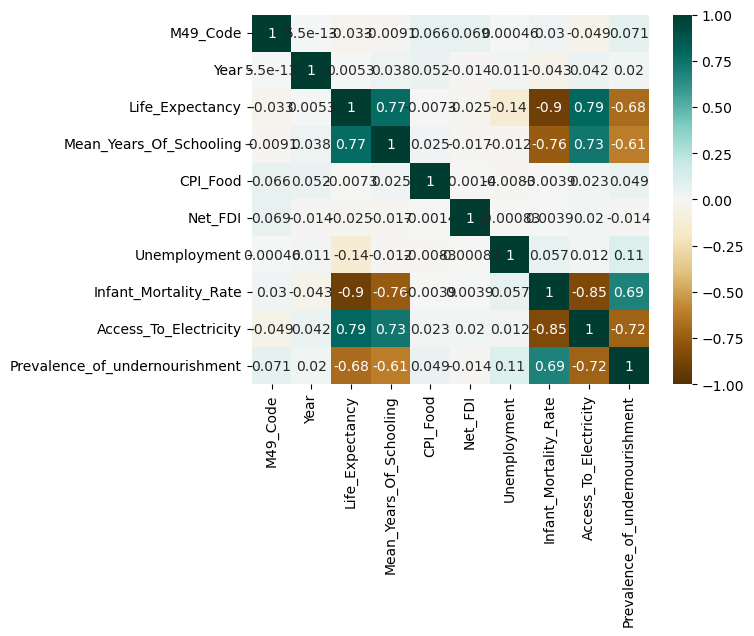

In [40]:
## Heatmap

corr = df_all_processed.corr()
# print(corr)
fig = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap="BrBG")
plt.show()
save_fig(fig, BIVARIATE, "Heat_Map_Correlation.png")


## All DF Processed Dataset (Transposed Version)


In [87]:
df_all_processed_1 = pd.read_csv("..\..\Datasets\Processed\All_DF_Processed.csv")
df_all_processed_1.columns

Index(['ISO3_Code', 'Country_Name', 'M49_Code', 'Life_Expectancy_2016',
       'Life_Expectancy_2017', 'Life_Expectancy_2018', 'Life_Expectancy_2019',
       'Life_Expectancy_2020', 'Mean_Years_Of_Schooling_2016',
       'Mean_Years_Of_Schooling_2017', 'Mean_Years_Of_Schooling_2018',
       'Mean_Years_Of_Schooling_2019', 'Mean_Years_Of_Schooling_2020',
       'CPI_Food_2016', 'CPI_Food_2017', 'CPI_Food_2018', 'CPI_Food_2019',
       'CPI_Food_2020', 'Net_FDI_2016', 'Net_FDI_2017', 'Net_FDI_2018',
       'Net_FDI_2019', 'Net_FDI_2020', 'Infant_Mortality_Rate_2016',
       'Infant_Mortality_Rate_2017', 'Infant_Mortality_Rate_2018',
       'Infant_Mortality_Rate_2019', 'Infant_Mortality_Rate_2020',
       'Unemployment_2016', 'Unemployment_2017', 'Unemployment_2018',
       'Unemployment_2019', 'Unemployment_2020', 'Access_To_Electricity_2016',
       'Access_To_Electricity_2017', 'Access_To_Electricity_2018',
       'Access_To_Electricity_2019', 'Access_To_Electricity_2020',
       'Fer

### Transposed Processed DF Pre-Processing


In [64]:
print(df_all_processed_1["CPI_Food_2016"].max())
print(df_all_processed_1["CPI_Food_2016"].min())

print(df_all_processed_1.loc[:, ["Country_Name", "Net_FDI_2020"]].sort_values(by="Net_FDI_2020", ascending=False))

953.574367
89.025426
                                          Country_Name  Net_FDI_2020
60                                             Ireland   82898.34679
140                           United States of America   63510.00000
47   United Kingdom of Great Britain and Northern I...   53133.33333
59                                               India   52501.95178
17                                              Brazil   50586.15178
..                                                 ...           ...
21                                              Canada  -24832.36439
45                                              France  -26270.52242
22                                         Switzerland  -63939.47576
81                                          Luxembourg  -64941.87361
68                                               Japan -105449.08350

[148 rows x 2 columns]


### Creating Cat Cols from Numerical Cols

*Year-on-Year analysis*

1. For each Year => Map the respective independent variable cols to cat cols
2. Plot univariate plots for Prevalence of Undernourishment with Hue of the generated Cat Cols
3. Plot bivariate plots for Prevalence of Undernourishment (y) and Generated Cat Cols (x)

In [82]:
## Max Min

# print(df_all_processed_1["Unemployment_2020"].max())
# print(df_all_processed_1["Unemployment_2020"].min())

# print(df_all_processed_1["Access_To_Electricity_2016"].max())
# print(df_all_processed_1["Access_To_Electricity_2016"].min())

# print(df_all_processed_1["Mean_Years_Of_Schooling_2016"].max())
# print(df_all_processed_1["Mean_Years_Of_Schooling_2016"].min())

# print(df_all_processed_1["Mean_Years_Of_Schooling_2016"].max())
# print(df_all_processed_1["Mean_Years_Of_Schooling_2016"].min())

# print(df_all_processed_1["Net_FDI_2016"].max())
# print(df_all_processed_1["Net_FDI_2016"].min())

# print(df_all_processed_1["Net_FDI_2017"].max())
# print(df_all_processed_1["Net_FDI_2017"].min())

# print(df_all_processed_1["Net_FDI_2018"].max())
# print(df_all_processed_1["Net_FDI_2018"].min())

# print(df_all_processed_1["Net_FDI_2019"].max())
# print(df_all_processed_1["Net_FDI_2019"].min())

# print(df_all_processed_1["Net_FDI_2020"].max())
# print(df_all_processed_1["Net_FDI_2020"].min())

print(df_all_processed_1["Corruption_Perception_Index_2020"].max())
print(df_all_processed_1["Corruption_Perception_Index_2020"].min())

print(df_all_processed_1["Corruption_Perception_Index_2016"].max())
print(df_all_processed_1["Corruption_Perception_Index_2016"].min())
"""
Ranges
Unemployment: 0.3 - 29.3
Access to Electricity: 9 - 100
Mean Years of Schooling: 1 - 15
NET FDI: -155000 - 85000
"""

88.0
12.0
90.0
10.0


'\nRanges\nUnemployment: 0.3 - 29.3\nAccess to Electricity: 9 - 100\nMean Years of Schooling: 1 - 15\nNET FDI: -155000 - 85000\n'

In [101]:
## Creating Cat Cols
cols_dict = {
    "Prevalence" : ["Prevalence_of_undernourishment_2016", "Prevalence_of_undernourishment_2017", "Prevalence_of_undernourishment_2018","Prevalence_of_undernourishment_2019","Prevalence_of_undernourishment_2020"],
    "Life_Expectancy" : ['Life_Expectancy_2016','Life_Expectancy_2017', 'Life_Expectancy_2018', 'Life_Expectancy_2019','Life_Expectancy_2020'],
    "CPI_Food": ['CPI_Food_2016', 'CPI_Food_2017', 'CPI_Food_2018', 'CPI_Food_2019', 'CPI_Food_2020'],
    "Net_FDI": ['Net_FDI_2016', 'Net_FDI_2017','Net_FDI_2018', 'Net_FDI_2019', 'Net_FDI_2020'],
    "Unemployment": [ 'Unemployment_2016', 'Unemployment_2017', 'Unemployment_2018','Unemployment_2019', 'Unemployment_2020'],
    "Mean_Years_of_Schooling": ['Mean_Years_Of_Schooling_2016','Mean_Years_Of_Schooling_2017', 'Mean_Years_Of_Schooling_2018','Mean_Years_Of_Schooling_2019', 'Mean_Years_Of_Schooling_2020'],
    "Access_To_Electricity": ['Access_To_Electricity_2016', 'Access_To_Electricity_2017', 'Access_To_Electricity_2018','Access_To_Electricity_2019', 'Access_To_Electricity_2020',],
    "Corruption_Index": ["Corruption_Perception_Index_2016", 'Corruption_Perception_Index_2017', 'Corruption_Perception_Index_2018','Corruption_Perception_Index_2019','Corruption_Perception_Index_2020']
}

def create_cat_cols(
    df_in : pd.DataFrame,
    cols_dict: dict,
    key: str,
    boundary_intervals_values: list,
    boundary_intervals_names: list
):  
    for item in range(len(cols_dict[key])):
        df_in[f"{cols_dict[key][item]}_Cat"] = pd.cut(df_in[cols_dict[key][item]], bins=boundary_intervals_values, labels=boundary_intervals_names)
    return df_in

In [102]:
# Life Expectancy
df_all_processed_1 = create_cat_cols(df_all_processed_1, cols_dict, "Life_Expectancy", [50,60,70,80,90], ["50-60","60-70","70-80","80-90"])

# Unemployment
df_all_processed_1 = create_cat_cols(df_all_processed_1, cols_dict, "Unemployment", [0,5,10,15,20,25,30], ["0-5", "5-10","10-15","15-20","20-25","25-30"])

# Mean Years of Schooling
df_all_processed_1 = create_cat_cols(df_all_processed_1, cols_dict, "Mean_Years_of_Schooling", [0,5,10,15], ["0-5", "5-10","10-15"])

# Access to Electricity
df_all_processed_1 = create_cat_cols(df_all_processed_1, cols_dict, "Access_To_Electricity", [0,20,40,60,80,100], ["0-20", "20-40","40-60","60-80","80-100"])

## Net FDI
# NET FDI 2020: -155000 - 85000
df_all_processed_1 = create_cat_cols(df_all_processed_1, cols_dict, "Net_FDI", [-155000,-100000,-50000,0,50000,100000], ["(-155000)-(-100000)","(-100000)-(-50000)","(-50000)-0","0-50000", "50000-100000"])

# Corruption Index
df_all_processed_1 = create_cat_cols(df_all_processed_1, cols_dict, "Corruption_Index", [0,20,40,60,80,100], ["0-20", "20-40","40-60","60-80","80-100"])

# CPI Cat
df_all_processed_1 = create_cat_cols(df_all_processed_1, cols_dict, "CPI_Food", [0,20,40,60,80,100], ["0-20", "20-40","40-60","60-80","80-100"])

df_all_processed_1.columns

Index(['ISO3_Code', 'Country_Name', 'M49_Code', 'Life_Expectancy_2016',
       'Life_Expectancy_2017', 'Life_Expectancy_2018', 'Life_Expectancy_2019',
       'Life_Expectancy_2020', 'Mean_Years_Of_Schooling_2016',
       'Mean_Years_Of_Schooling_2017', 'Mean_Years_Of_Schooling_2018',
       'Mean_Years_Of_Schooling_2019', 'Mean_Years_Of_Schooling_2020',
       'CPI_Food_2016', 'CPI_Food_2017', 'CPI_Food_2018', 'CPI_Food_2019',
       'CPI_Food_2020', 'Net_FDI_2016', 'Net_FDI_2017', 'Net_FDI_2018',
       'Net_FDI_2019', 'Net_FDI_2020', 'Infant_Mortality_Rate_2016',
       'Infant_Mortality_Rate_2017', 'Infant_Mortality_Rate_2018',
       'Infant_Mortality_Rate_2019', 'Infant_Mortality_Rate_2020',
       'Unemployment_2016', 'Unemployment_2017', 'Unemployment_2018',
       'Unemployment_2019', 'Unemployment_2020', 'Access_To_Electricity_2016',
       'Access_To_Electricity_2017', 'Access_To_Electricity_2018',
       'Access_To_Electricity_2019', 'Access_To_Electricity_2020',
       'Fer

### Univariate Analysis

In [38]:
def plot_transposed_df_univariate(
    df_in: pd.DataFrame,
    save_dest: str,
    cols_dict: dict,
    key: str,
    x: str = "Prevalence_of_undernourishment",
    
    
):  
    dest_path = os.path.join(UNIVARIATE, save_dest)
    if not os.path.isdir(dest_path):
        os.mkdir(dest_path)
    year_l = [2016,2017,2018,2019,2020]
    plot_types = ["Hist", "KDE"]
    for item in range(len(cols_dict[key])):
        for plot_type in plot_types:
            fig = PLOTS_TO_FUNC[plot_type](data=df_in, x=f"{x}_{year_l[item]}", hue=f"{cols_dict[key][item]}_Cat")
            file_name = f"{plot_type}_plot_{x}_hue_{cols_dict[key][item]}.png"
            save_fig(fig, dest_path, file_name)

# Hue == Life Expectancy
plot_transposed_df_univariate(df_in=df_all_processed_1, save_dest="Transposed/Hue_Life_Expectancy",cols_dict=cols_dict, key="Life_Expectancy",x="Prevalence_of_undernourishment")

# Hue == Unemployment
plot_transposed_df_univariate(df_in=df_all_processed_1, save_dest="Transposed/Hue_Unemployment",cols_dict=cols_dict, key="Unemployment",x="Prevalence_of_undernourishment")

# Hue == Mean Years of Schooling
plot_transposed_df_univariate(df_in=df_all_processed_1, save_dest="Transposed/Hue_Mean_Yrs_Schooling",cols_dict=cols_dict, key="Mean_Years_of_Schooling",x="Prevalence_of_undernourishment")

# Hue == Access to Electricity
plot_transposed_df_univariate(df_in=df_all_processed_1, save_dest="Transposed/Hue_Access_To_Electricity",cols_dict=cols_dict, key="Access_To_Electricity",x="Prevalence_of_undernourishment")

### Findings from Univariate Analysis
1. Access to Electricity, Unemployment, Mean Years of Schooling, Life Expectancy have an inverse relationship with Prevalence of Undernourishment 
- This gives us confirmation from our initial insight using the heatmap of correlation between columns


## Bivariate Analysis

In [92]:
def plot_transposed_df_bivariate_hue(
    df_in: pd.DataFrame,
    save_dest: str,
    cols_dict: dict,
    key: str,
    hue_l = str,
    x: str = "Prevalence_of_undernourishment",
):  
    dest_path = os.path.join(BIVARIATE, save_dest)
    if not os.path.isdir(dest_path):
        os.mkdir(dest_path)
    year_l = [2016,2017,2018,2019,2020]
    plot_types = ["Bar", "Violin", "Scatter"]
    
    for item in range(len(cols_dict[key])):
        for plot_type in plot_types:
            fig = PLOTS_TO_FUNC[plot_type](data=df_in,x=f"{cols_dict[key][item]}_Cat", y=f"{x}_{year_l[item]}", hue=f"{cols_dict[hue_l][item]}_Cat")
            file_name = f"{plot_type}_plot_y_{x}_x_{cols_dict[key][item]}.png"
            save_fig(fig, dest_path, file_name)

def plot_transposed_df_bivariate_no_hue(
    df_in: pd.DataFrame,
    save_dest: str,
    cols_dict: dict,
    key: str,
    x: str = "Prevalence_of_undernourishment",
):  
    dest_path = os.path.join(BIVARIATE, save_dest)
    if not os.path.isdir(dest_path):
        os.mkdir(dest_path)
    year_l = [2016,2017,2018,2019,2020]
    plot_types = ["Bar", "Violin", "Scatter"]

    for item in range(len(cols_dict[key])):
        for plot_type in plot_types:
            fig = PLOTS_TO_FUNC[plot_type](data=df_in,x=f"{cols_dict[key][item]}_Cat", y=f"{x}_{year_l[item]}")
            file_name = f"{plot_type}_plot_y_{x}_x_{cols_dict[key][item]}.png"
            save_fig(fig, dest_path, file_name)

In [ ]:
# X == Life Expectancy
plot_transposed_df_bivariate_hue(df_in=df_all_processed_1, save_dest="Transposed/x_Life_Expectancy",cols_dict=cols_dict, key="Life_Expectancy",hue_l="Unemployment" , x="Prevalence_of_undernourishment")

# X == Unemployment
# plot_transposed_df_bivariate(df_in=df_all_processed_1, save_dest="Transposed/x_Unemployment",cols_dict=cols_dict, key="Unemployment",x="Prevalence_of_undernourishment")

# # X == Mean Years of Schooling
# plot_transposed_df_bivariate(df_in=df_all_processed_1, save_dest="Transposed/x_Mean_Yrs_Schooling",cols_dict=cols_dict, key="Mean_Years_of_Schooling",x="Prevalence_of_undernourishment")

# # X == Access to Electricity
# plot_transposed_df_bivariate(df_in=df_all_processed_1, save_dest="Transposed/x_Access_To_Electricity",cols_dict=cols_dict, key="Access_To_Electricity",x="Prevalence_of_undernourishment")

1. Bivariate
- Net FDI cat vs Prevalence
- Access to electricity cat vs Prevalence
- Corruption index cat vs Prevalence
- Life Expectancy cat vs Fertility rate => these two vars seem interchangable
- Mean years of schooling cat vs fertility rate => these two vars seem interchangable
- CPI Food cat vs Prevalence (remove outliers in linear regression ipynb file)

In [93]:
## Net FDI vs Prevalence
plot_transposed_df_bivariate_no_hue(df_in=df_all_processed_1, save_dest="Transposed/x_Net_FDI",cols_dict=cols_dict, key="Net_FDI", x="Prevalence_of_undernourishment")

## Access to Electricity vs Prevalence
plot_transposed_df_bivariate_no_hue(df_in=df_all_processed_1, save_dest="Transposed/x_Access_To_Electricity",cols_dict=cols_dict, key="Access_To_Electricity", x="Prevalence_of_undernourishment")

## Corruption Index vs Prevalence
plot_transposed_df_bivariate_no_hue(df_in=df_all_processed_1, save_dest="Transposed/x_Corruption_Index",cols_dict=cols_dict, key="Corruption_Index", x="Prevalence_of_undernourishment")

## Life Expectancy Cat vs Fertility Rate
plot_transposed_df_bivariate_no_hue(df_in=df_all_processed_1, save_dest="Transposed/x_Life_expectancy_y_Fertility_Rate",cols_dict=cols_dict, key="Life_Expectancy", x="Fertility_Rate")

## Mean Years of Schooling Cat vs Fertility Rate
plot_transposed_df_bivariate_no_hue(df_in=df_all_processed_1, save_dest="Transposed/x_Mean_Yrs_Schooling_y_Fertility_Rate",cols_dict=cols_dict, key="Mean_Years_of_Schooling", x="Fertility_Rate")

## CPI Food Cat vs Prevalence
plot_transposed_df_bivariate_no_hue(df_in=df_all_processed_1, save_dest="Transposed/x_CPI_Food",cols_dict=cols_dict, key="CPI_Food", x="Prevalence_of_undernourishment")

In [95]:
df_all_processed_1["Fertility_Rate_2020"].max()

5.885